### Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.listdir()

['.~Book1__42404.twbr',
 'E-Commerce-Dataset.ipynb',
 'Dashboard.png',
 '.DS_Store',
 'cleaned_data.csv',
 '.E-Commerce-Dataset.ipynb.layout',
 '.ipynb_checkpoints',
 'E-Commerce-Dataset.twb',
 'ecommerce_dataset_updated.csv']

# Dataset Overview

In [6]:
# зчитуємо дані у датафрейм

df = pd.read_csv('ecommerce_dataset_updated.csv')
df.head()

,User_ID,Product_ID,Category,Price (Rs.),Discount (%),Final_Price(Rs.),Payment_Method,Purchase_Date
0,337c166f,f414122f-e,Sports,36.53,15,31.05,Net Banking,12-11-2024
1,d38a19bf,fde50f9c-5,Clothing,232.79,20,186.23,Net Banking,09-02-2024
2,d7f5f0b0,0d96fc90-3,Sports,317.02,25,237.76,Credit Card,01-09-2024
3,395d4994,964fc44b-d,Toys,173.19,25,129.89,UPI,01-04-2024
4,a83c145c,d70e2fc6-e,Beauty,244.80,20,195.84,Net Banking,27-09-2024


In [8]:
# знайомимось з даними, назвами колонок та типами даних
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660 entries, 0 to 3659
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   User_ID           3660 non-null   object 
 1   Product_ID        3660 non-null   object 
 2   Category          3660 non-null   object 
 3   Price (Rs.)       3660 non-null   float64
 4   Discount (%)      3660 non-null   int64  
 5   Final_Price(Rs.)  3660 non-null   float64
 6   Payment_Method    3660 non-null   object 
 7   Purchase_Date     3660 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 228.9+ KB


In [10]:
# розмір датасету
df.shape

(3660, 8)

In [12]:
df.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9])

,Price (Rs.),Discount (%),Final_Price(Rs.)
count,3660.000000,3660.000000,3660.000000
mean,254.800675,18.825137,206.906579
std,141.682621,14.731338,122.687844
min,10.090000,0.000000,5.890000
1%,14.633600,0.000000,11.462600
10%,56.085000,0.000000,44.281000
25%,134.012500,5.000000,104.512500
50%,253.845000,15.000000,199.185000
75%,377.595000,25.000000,304.117500
90%,450.532000,50.000000,379.114000


# Data Cleaning and Preprocessing

In [15]:
# перевіряємо датасет на null (наявність пропущених значень)
df.isnull().sum()

User_ID             0
Product_ID          0
Category            0
Price (Rs.)         0
Discount (%)        0
Final_Price(Rs.)    0
Payment_Method      0
Purchase_Date       0
dtype: int64

Датасет не містить пропущених значень.

In [18]:
# перевіряємо датасет на дублікати
sum(df.duplicated())

0

Датасет не містить дублікатів.

In [21]:
# перевірки числових колонок на відʼємні значення
invalid_prices = df[
   (df['Price (Rs.)'] < 0) | 
   (df['Discount (%)'] < 0) |
   (df['Final_Price(Rs.)'] < 0)
]
print(invalid_prices)

Empty DataFrame
Columns: [User_ID, Product_ID, Category, Price (Rs.), Discount (%), Final_Price(Rs.), Payment_Method, Purchase_Date]
Index: []


Датасет не містить відʼємних значень.

In [24]:
# приведення назв колонок до уніфікованого виду
df.columns

Index(['User_ID', 'Product_ID', 'Category', 'Price (Rs.)', 'Discount (%)',
       'Final_Price(Rs.)', 'Payment_Method', 'Purchase_Date'],
      dtype='object')

In [26]:
df.columns = (df.columns
              .str.lower()
              .str.replace(r'\(.*\)', '', regex=True)
              .str.strip()
             )
df.columns

Index(['user_id', 'product_id', 'category', 'price', 'discount', 'final_price',
       'payment_method', 'purchase_date'],
      dtype='object')

# Exploratory Data Analysis (EDA)

## 1. Аналіз продажів товарів

- Які товари приносять найбільший дохід/продаються найкраще?
- Які категорії товарів продаються найкраще в різні періоди року?
- Чи є сезонні коливання в продажах?

In [30]:
# групування за категорією та обчислення сумарного доходу
category_revenue = df.groupby('category')['final_price'].sum()

# сортування за спаданням та пошук категорії з найбільшим доходом
top_category = category_revenue.sort_values(ascending=False).reset_index()

top_category

,category,final_price
0,Clothing,115314.84
1,Books,111149.35
2,Home & Kitchen,110328.08
3,Sports,108518.79
4,Toys,107289.69
5,Beauty,104215.10
6,Electronics,100462.23


#### Висновок:
Категорія товарів `Одяг` є лідером продажів та приносить найбільший дохід – 115 314,84. Найменший прибуток забезпечує категорія `Електроніка` – 100 462,23. Це може бути зумовлено тим, що одяг купують частіше через необхідність оновлення гардеробу та його відносну доступність у порівнянні з технікою. Водночас електроніка є дорожчою та купується рідше, оскільки пристрої зазвичай використовуються протягом тривалого часу.

Порахуємо сумарний дохід по категоріях товарів за місяцями

In [34]:
# перетворення у формат дати та створення нових колонок
df['purchase_date'] = pd.to_datetime(df['purchase_date'], format="%d-%m-%Y", errors='coerce')

df['month'] = df['purchase_date'].dt.month

In [36]:
monthly_sales_total_pivot = df.pivot_table(index='month', columns='category', values='final_price', aggfunc='sum', fill_value=0)

monthly_sales_total_pivot

category,Beauty,Books,Clothing,Electronics,Home & Kitchen,Sports,Toys
month,,,,,,,
1,10909.32,8858.16,10664.28,8439.91,10421.69,9981.53,9734.54
2,12039.20,7516.03,10471.59,11238.46,10338.02,10225.61,7357.43
3,11088.45,8495.20,12820.30,8216.37,10063.40,12143.32,8498.36
4,8542.71,9346.81,15876.86,7747.77,11814.25,11756.67,9280.06
5,10688.15,10194.79,8243.46,9453.03,8723.17,11395.04,10139.61
6,5934.21,8916.94,8109.12,11638.59,8029.62,8237.01,13391.17
7,8895.84,11455.91,9840.52,10889.77,10670.41,10840.61,10205.17
8,8106.25,10437.67,8853.21,10592.97,12812.65,8928.81,11775.40
9,11429.78,11260.05,9351.98,5321.05,11340.52,9594.97,9744.74


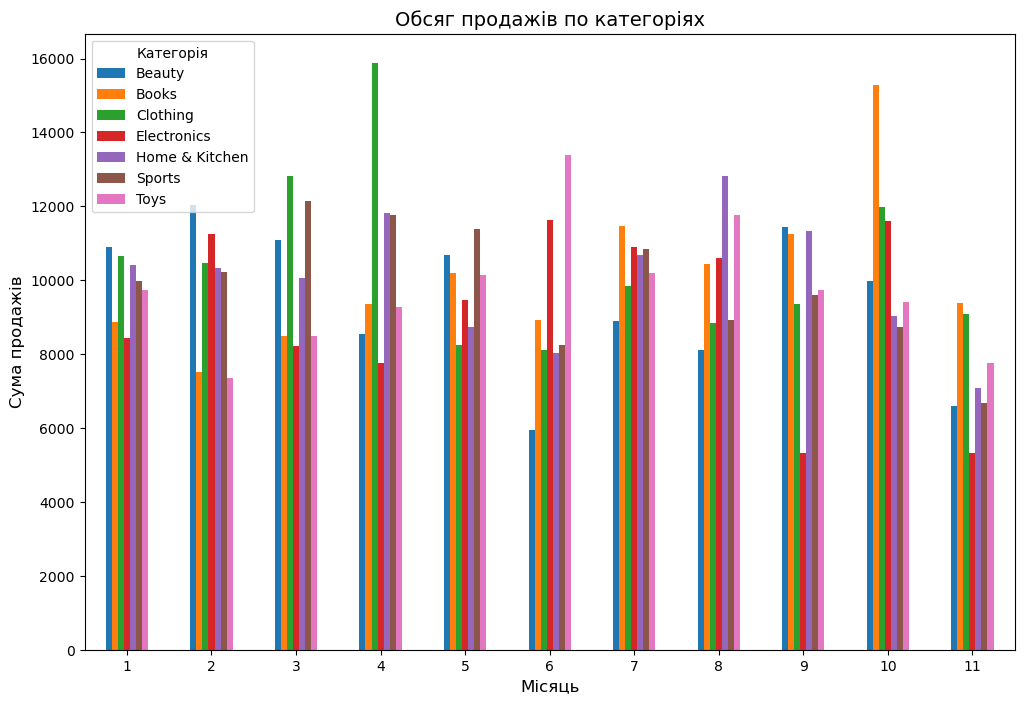

In [38]:
monthly_sales_total_pivot.plot(kind='bar', stacked=False, figsize=(12, 8))
plt.title('Обсяг продажів по категоріях', fontsize=14)
plt.xlabel('Місяць', fontsize=12)
plt.ylabel('Сума продажів', fontsize=12)
plt.legend(title='Категорія')
plt.xticks(rotation=0)
plt.show()

#### Висновок:
З графіка видно, що категорія `Одяг` має пікові продажі навесні — у березні та квітні. Це може бути зумовлено оновленням гардеробу до теплого сезону та бажанням виглядати сучасно та по-новому. Також весняні розпродажі та акції можуть додатково стимулювати покупки.

Натомість категорія `Книги` демонструє найбільший попит восени, зокрема в жовтні. Це може бути пов'язано з початком навчального року, популярністю читання в затишний осінній сезон та підготовкою до зимових свят.

Такі тенденції допомагають краще планувати маркетингові кампанії та акції залежно від сезону, що сприятиме збільшенню продажів.

## 2. Аналіз обсягу продажів за місяцями

In [42]:
monthly_sales_by_month = df.groupby('month')['final_price'].sum()

monthly_sales_by_month.sort_values(ascending=False).reset_index()

,month,final_price
0,10,76034.51
1,4,74365.13
2,7,72798.23
3,8,71506.96
4,3,71325.40
5,2,69186.34
6,1,69009.43
7,5,68837.25
8,9,68043.09
9,6,64256.66


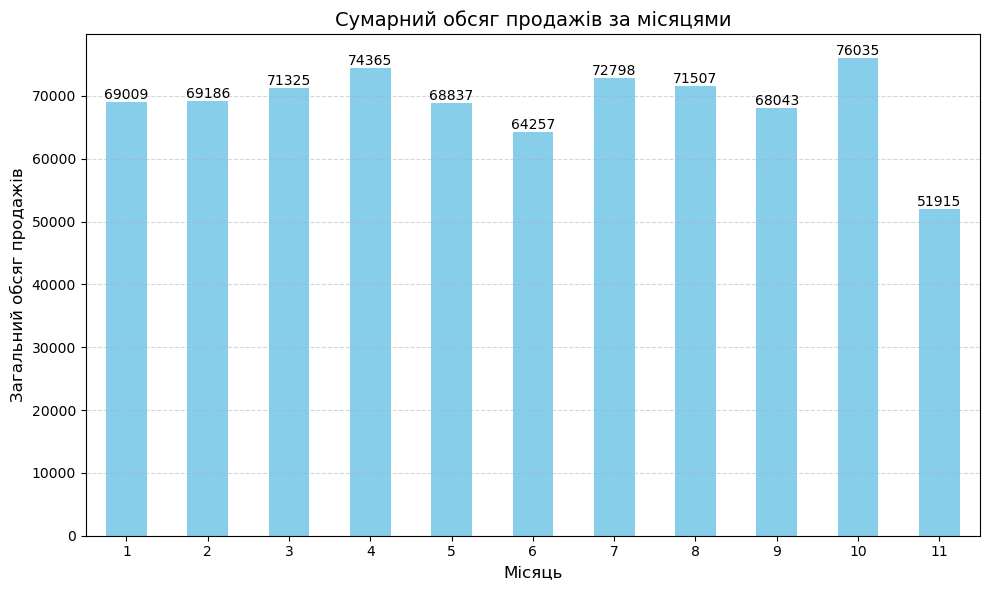

In [44]:
plt.figure(figsize=(10, 6))
monthly_sales_by_month.plot(kind='bar', color='skyblue')
plt.title('Сумарний обсяг продажів за місяцями', fontsize=14)
plt.xlabel('Місяць', fontsize=12)
plt.ylabel('Загальний обсяг продажів', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)

for index, value in enumerate(monthly_sales_by_month):
    plt.text(index, value, f'{value:.0f}', ha='center', va='bottom', fontsize=10, fontweight='medium')

plt.tight_layout()
plt.show()

#### Висновок:
Аналіз обсягу продажів показав, що найбільший дохід було отримано у квітні та жовтні 2024 року, за ними йдуть липень та серпень. Загалом, обсяги продажів протягом року залишаються стабільними, що свідчить про відсутність вираженої сезонності. Можна припустити, що асортимент товарів добре збалансований та відповідає попиту в різні періоди року.

На графіку також видно значне зменшення продажів у листопаді. Ймовірною причиною цього може бути неповна вибірка даних за місяць або інші фактори, що потребують додаткового аналізу. Відсутність даних за грудень не дозволяє зробити повноцінний висновок щодо річної динаміки продажів.

Щоб підтвердити припущення, варто проаналізувати кількість транзакцій у листопаді порівняно з іншими місяцями. Це допоможе зрозуміти, чи пов'язане зниження обсягу продажів зі зменшенням кількості операцій або з іншими чинниками.

In [47]:
transactions_per_month = df.groupby('month')['final_price'].count().reset_index(name='transaction_count')

transactions_per_month

,month,transaction_count
0,1,340
1,2,308
2,3,355
3,4,362
4,5,333
5,6,323
6,7,346
7,8,344
8,9,342
9,10,362


In [49]:
transactions_per_month.mean()

month                  6.000000
transaction_count    332.727273
dtype: float64

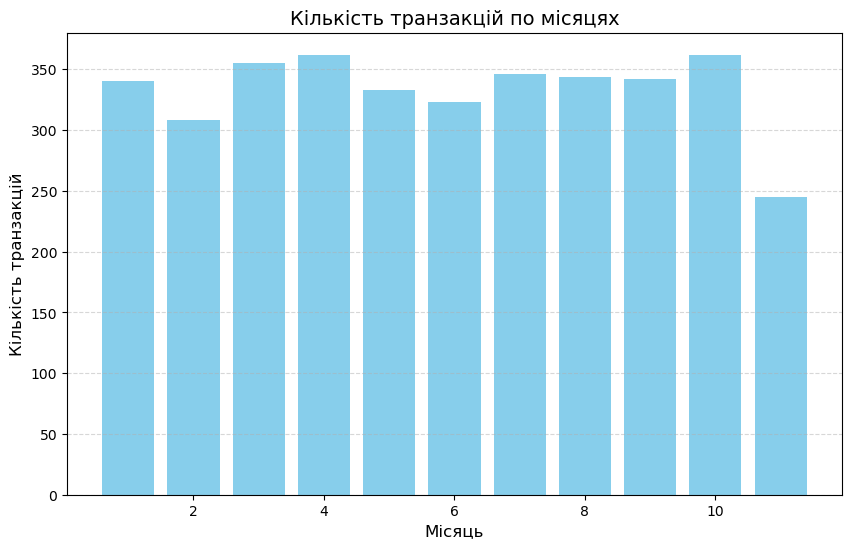

In [51]:
plt.figure(figsize=(10, 6))
plt.bar(transactions_per_month['month'], transactions_per_month['transaction_count'], color='skyblue')
plt.xlabel('Місяць', fontsize=12)
plt.ylabel('Кількість транзакцій', fontsize=12)
plt.title('Кількість транзакцій по місяцях', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

Кількість транзакцій у листопаді дійсно значно менша — лише 245, тоді як середня кількість транзакцій за попередні місяці становила близько 332. Тому можна сміливо стверджувати, що дані за листопад є неповними, що ускладнює формування точних висновків щодо тенденцій продажів саме в цьому місяці.

In [54]:
monthly_sales = df.pivot_table(
    values='final_price', 
    index='category', 
    columns='month', 
    aggfunc='sum',
    fill_value=0
)

Побудуємо ще один графік для наочного порівняння продажів за періодами.

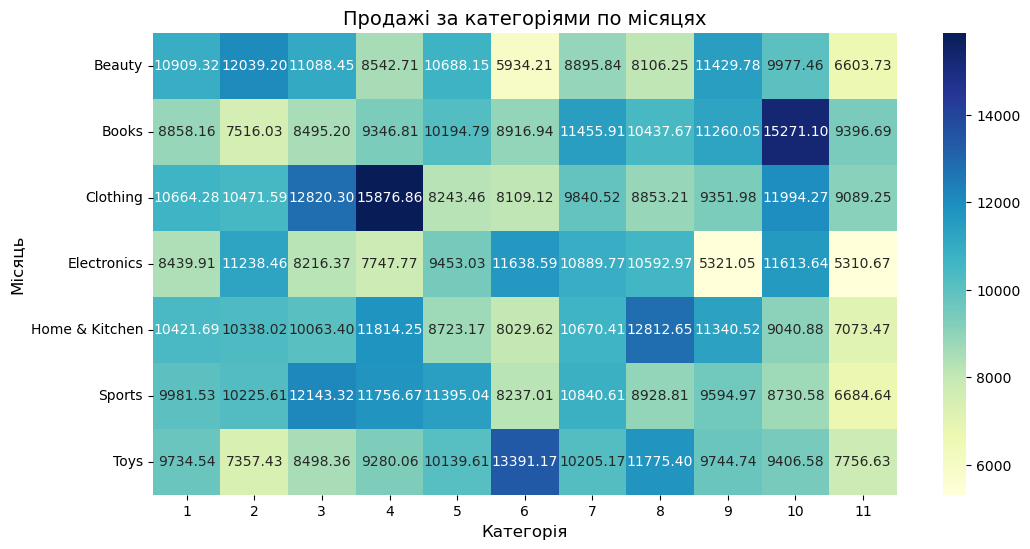

In [57]:
# аналіз за місяцями

plt.figure(figsize=(12, 6))
sns.heatmap(monthly_sales, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Продажі за категоріями по місяцях", fontsize=14)
plt.xlabel("Категорія", fontsize=12)
plt.ylabel("Місяць", fontsize=12)
plt.show()

#### Висновок:
З теплової карти видно, що найбільший прибуток забезпечила категорія `Одяг` у квітні та категорія `Книги` у жовтні, як вже відзначалося раніше. Найменш прибутковими виявилися категорії `Електроніка` у вересні та листопаді, а також `Краса` у червні та листопаді. Решта категорій демонструють стабільні показники прибутку та рівномірно розподіляються за місяцями.

## 3. Розподіл кількості транзакцій за методами оплати
- Який спосіб оплати найпопулярніший?

In [61]:
# підрахунок кількості транзакцій за кожним методом оплати

payment_method_counts = df['payment_method'].value_counts()

In [63]:
payment_method_counts

Credit Card         760
UPI                 757
Debit Card          731
Net Banking         716
Cash on Delivery    696
Name: payment_method, dtype: int64

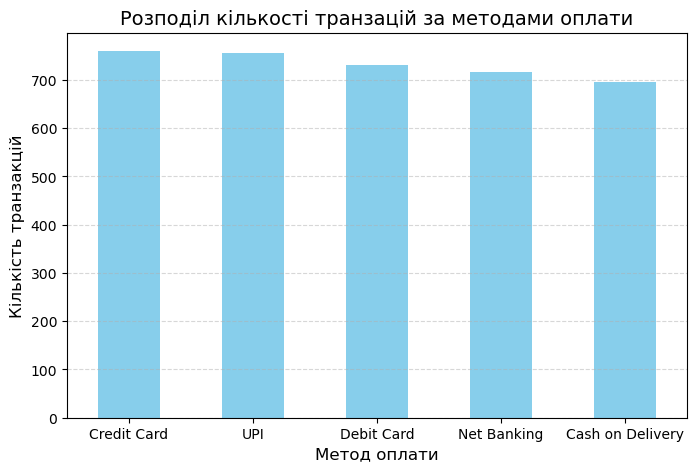

In [65]:
plt.figure(figsize=(8, 5))
payment_method_counts.plot(kind='bar', color='skyblue')
plt.title("Розподіл кількості транзацій за методами оплати", fontsize=14)
plt.xlabel("Метод оплати", fontsize=12)
plt.ylabel("Кількість транзакцій", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.show()

## 4. Розподіл прибутку залежно від методу оплати

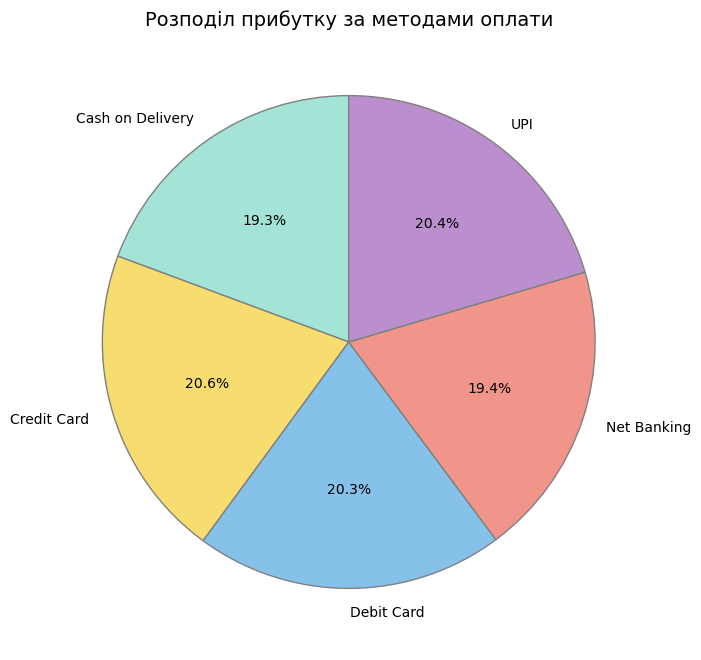

In [68]:
# розрахунок прибутку за методами оплати
payment_method_revenue = df.groupby('payment_method')['final_price'].sum()
payment_method_revenue_percentage = (payment_method_revenue / payment_method_revenue.sum()) * 100

plt.figure(figsize=(8, 8))
plt.pie(payment_method_revenue_percentage, 
        labels=payment_method_revenue_percentage.index,
        autopct='%1.1f%%',
        colors=['#A3E4D7', '#F7DC6F', '#85C1E9', '#F1948A', '#BB8FCE'],
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'grey'})

plt.title("Розподіл прибутку за методами оплати", fontsize=14)
plt.show()

#### Висновок:
Більшість методів оплати мають приблизно однакову частку (близько 20%) та однакову популярність. Винятком є Cash on Delivery (19,3%) та Net Banking (19,4%), які використовуються трохи рідше. Отже, серед клієнтів немає чітко вираженого пріоритетного способу оплати.

## 5. Який метод оплати найпопулярніший у різні періоди року?
- Подивитися зміну популярності методів оплати.

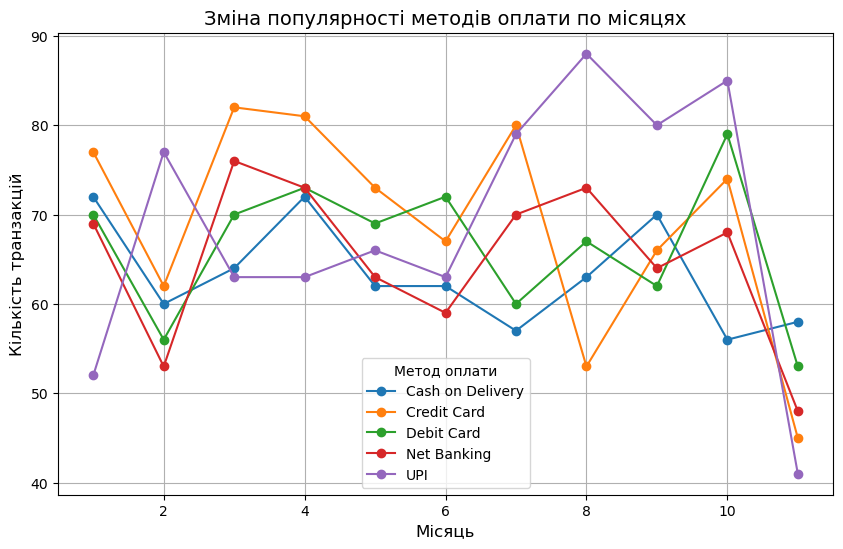

In [72]:
# кількість транзакцій за методами оплати по місяцях
payment_trends = df.pivot_table(
    index='month', 
    columns='payment_method', 
    values='user_id', 
    aggfunc='count'
).fillna(0)

payment_trends.plot(kind='line', marker='o', figsize=(10, 6))
plt.title("Зміна популярності методів оплати по місяцях", fontsize=14)
plt.xlabel("Місяць", fontsize=12)
plt.ylabel("Кількість транзакцій", fontsize=12)
plt.grid(True)
plt.legend(title="Метод оплати")
plt.show()

#### Висновок:
З аналізу популярності методів оплати по місяцях ми бачимо, що:
- Метод оплати UPI (миттєві перекази через додаток) мав пікові значення у серпні та жовтні.
- Кредитна картка (Credit Card) також залишається популярною протягом усього року.
- Найменш використовуваним методом оплати є готівка при доставці (Cash on Delivery), що може свідчити про зручність безготівкових платежів та більшу довіру до онлайн-оплат.

## 6. Чи є кореляція між ціною знижкою та обсягом продажів?

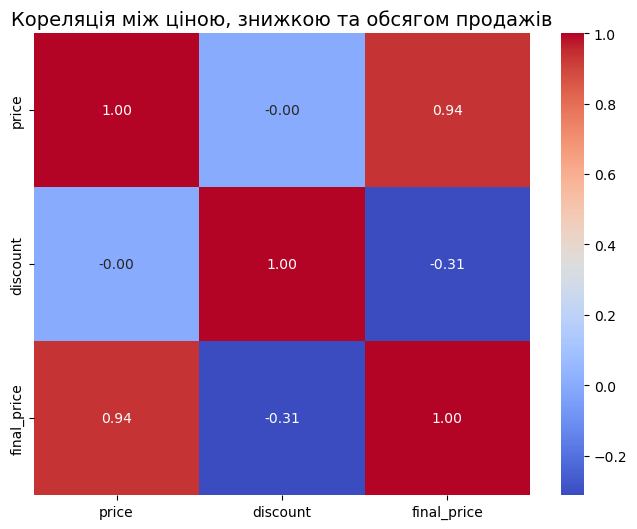

In [76]:
# обираємо потрібні колонки
correlation_data = df[['price', 'discount', 'final_price']]

# розраховуємо кореляцію
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Кореляція між ціною, знижкою та обсягом продажів", fontsize=14)
plt.show()

#### Висновок:
- Кореляція кінцевої ціни до початкової ціни 0.94.
Висока позитивна кореляція означає, що кінцева ціна сильно залежить від початкової ціни. Це логічно, адже кінцева ціна розраховується як початкова ціна за вирахуванням знижки.

- Кореляція дисконту до фінальної ціни -0.31.
Негативна кореляція середньої сили означає, що зі збільшенням дисконту кінцева ціна знижується. Чим більша знижка, тим менше покупець заплатить за товар.

## 7. Перевірити залежність обсягу продажів від дисконту

- Можливо, високі знижки збільшують обсяги продажів?

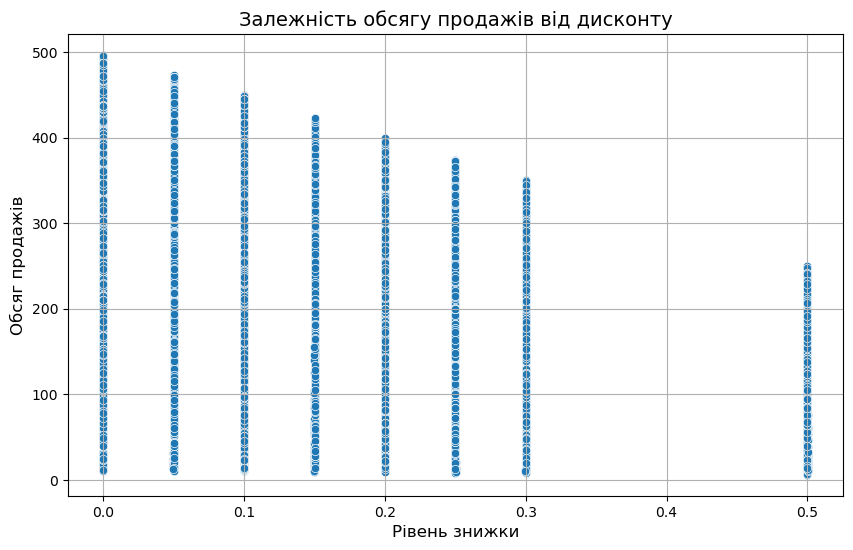

In [80]:
# розрахунок рівня знижки
df['discount_rate'] = (df['price'] - df['final_price']) / df['price']
sales_by_discount = df.groupby(pd.cut(df['discount_rate'], bins=[0, 0.1, 0.3, 0.5, 1]))['final_price'].sum()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['discount_rate'], y=df['final_price'])
plt.title("Залежність обсягу продажів від дисконту", fontsize=14)
plt.xlabel("Рівень знижки", fontsize=12)
plt.ylabel("Обсяг продажів", fontsize=12)
plt.grid(True)
plt.show()

#### Висновок:
Найбільший обсяг продажів припадає на товари з 0%, 5% та 10% знижкою.
- 0% (без знижки): Ці товари мають попит без знижок, що може свідчити про їхню високу популярність або оптимальну ціну.
- 5% та 10% знижка: Невеликі знижки створюють вигоду для покупців без значних втрат для компанії, що робить їх популярними.
- Зниження продажів після 10% знижки: можливо, покупці чекають на більші знижки, а також велика знижка може викликати асоціації з низькою якістю товару.

Це свідчить про те, що помірні знижки ефективніше стимулюють попит, ніж великі.

## 8. Яка середня вартість товарів по категоріях

- Порівняємо середні ціни для виявлення преміальних та бюджетних товарів.

In [84]:
# обчислення середньої вартості товарів по категоріях
avg_price_by_category = df.groupby('category')['price'].mean().round(2).sort_values(ascending=False)
avg_price_by_category

category
Clothing          263.12
Books             259.12
Sports            258.62
Beauty            252.74
Electronics       251.65
Home & Kitchen    249.26
Toys              248.96
Name: price, dtype: float64

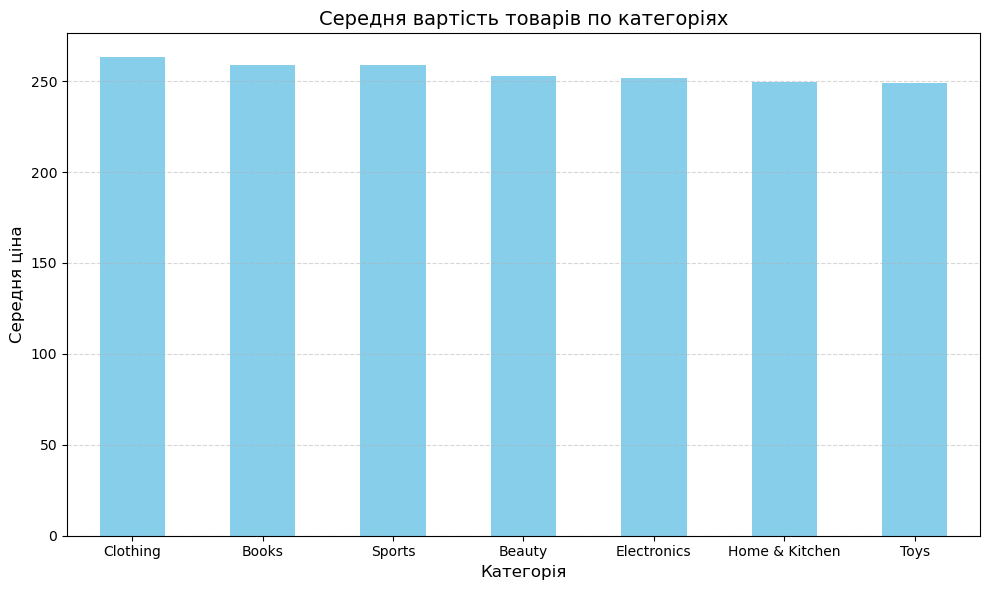

In [86]:
plt.figure(figsize=(10, 6))
avg_price_by_category.plot(kind='bar', color='skyblue')
plt.title("Середня вартість товарів по категоріях", fontsize=14)
plt.xlabel("Категорія", fontsize=12)
plt.ylabel("Середня ціна", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Висновок:
Як бачимо, середня ціна для категорій Одяг (263.12), Книги (259.12) та Спорт (258.62) знаходиться на одному рівні. Найменшу середню вартість має категорія Іграшки — 248.96. Це свідчить про те, що товари в цій категорії є більш доступними, тоді як інші категорії можна віднести до середнього цінового сегмента.

Майже однакова середня ціна у всіх категоріях може свідчити про обмеження синтетичних даних або відсутність інформації про кількість покупок. Це ускладнює визначення преміальних та бюджетних товарів, оскільки популярність продуктів та їх реальна вартість не враховані належним чином.

## 9. Який товар має найбільшу знижку та як це вплинуло на продажі
- Аналіз впливу розміру знижки на обсяги продажів.

In [90]:
df['discount'].sort_values().unique()

array([ 0,  5, 10, 15, 20, 25, 30, 50])

In [92]:
# знайдемо товар з найбільшою знижкою
max_discount_product = df.loc[df['discount'].idxmax()]

# визначимо категорію товару з найбільшою знижкою
max_discount_category = max_discount_product['category']
max_discount_category

'Books'

In [94]:
# створюємо список з унікальних рівнів знижки
discount_levels = [0, 5, 10, 15, 20, 25, 30, 50]

# підрахуємо обсяг продажів для кожного рівня знижки
sales_books_by_discount_level = {}

for discount in discount_levels:
    sales_books_by_discount_level[f'{discount}%'] = df[(df['category'] == 'Books') & (df['discount'] == discount)]['final_price'].sum()

sales_books_by_discount_level

{'0%': 16824.45,
 '5%': 15630.22,
 '10%': 14421.900000000001,
 '15%': 15425.560000000001,
 '20%': 16562.11,
 '25%': 12174.110000000002,
 '30%': 10909.99,
 '50%': 9201.01}

In [96]:
sales_books_by_discount_level = {
    '0%': df[(df['category'] == 'Books') & (df['discount'] == 0)]['final_price'].sum(),
    '5%': df[(df['category'] == 'Books') & (df['discount'] == 5)]['final_price'].sum(),
    '10%': df[(df['category'] == 'Books') & (df['discount'] == 10)]['final_price'].sum(),
    '15%': df[(df['category'] == 'Books') & (df['discount'] == 15)]['final_price'].sum(),
    '20%': df[(df['category'] == 'Books') & (df['discount'] == 20)]['final_price'].sum(),
    '25%': df[(df['category'] == 'Books') & (df['discount'] == 25)]['final_price'].sum(),
    '30%': df[(df['category'] == 'Books') & (df['discount'] == 30)]['final_price'].sum(),
    '50%': df[(df['category'] == 'Books') & (df['discount'] == 50)]['final_price'].sum()
}

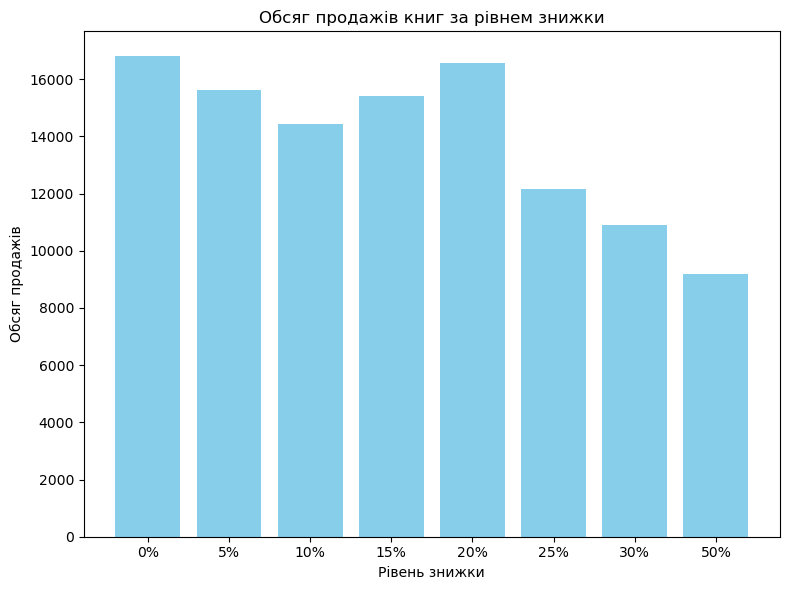

In [98]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(sales_books_by_discount_level.keys(), sales_books_by_discount_level.values(), color='skyblue')
ax.set_xlabel('Рівень знижки')
ax.set_ylabel('Обсяг продажів')
ax.set_title('Обсяг продажів книг за рівнем знижки')

# Показати графік
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Висновок:
З аналізу продажів видно, що категорія `Книги` має рекордні показники за обсягом продажів у жовтні та займає друге місце за прибутком серед усіх категорій. Це свідчить про позитивний вплив знижок на обсяги продажів саме в цій категорії. Знижки стимулюють попит, збільшуючи кількість покупок, що робить їх ефективною стратегією для підвищення продажів книг.

Найбільший прибуток спостерігається при знижках у межах 0-5% та 15-20%, що підтверджує ефективність застосування помірних знижок для залучення покупців без значних втрат у маржі.

## 10. Який день тижня найприбутковіший?
- Визначити дні з максимальними продажами.

In [102]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
df['day_of_week'] = df['purchase_date'].dt.day_name()

sales_by_day = df.groupby('day_of_week')['final_price'].sum()
sales_by_day_sorted = sales_by_day.sort_values(ascending=False)

sales_by_day_sorted

day_of_week
Sunday       115282.24
Thursday     113187.49
Tuesday      112299.98
Monday       108624.43
Friday       106048.81
Wednesday    103007.68
Saturday      98827.45
Name: final_price, dtype: float64

#### Висновок:
Неділя є найприбутковішим днем з обсягом продажів 115282.24, це може свідчити про те, що клієнти частіше здійснюють покупки в кінці тижня, можливо, через більше вільного часу або спеціальні пропозиції на вихідних. Цю інформацію можна використати для оптимізації маркетингових стратегій, наприклад, збільшити знижки або запустити акції в неділю для залучення ще більшої кількості покупців.

In [107]:
df.to_csv('cleaned_data.csv', index=False)

### Загальний підсумок:
Проведений аналіз дозволив глибше зрозуміти динаміку онлайн-продажів і клієнтську поведінку, виявивши кілька важливих закономірностей і потенційних точок зростання:

📚 **Категорія “Книги”** продемонструвала стабільно високі продажі, з піком у жовтні. Помірні знижки у **5–20%** мають найбільший вплив на прибуток — це вказує на доцільність використання таких знижок як інструменту стимулювання попиту без суттєвого зниження маржинальності.

📆 **Неділя** — найприбутковіший день тижня. Це свідчить про зростання купівельної активності у вихідні, що можна ефективно використати при плануванні рекламних кампаній, e-mail розсилок чи акцій, орієнтованих саме на кінець тижня.

💳 Виявлено **найпопулярніші методи оплати**, що допоможе оптимізувати користувацький досвід і зменшити відмови на етапі оформлення замовлення.

🔎 На основі отриманих даних можна сформувати **таргетовані маркетингові стратегії**, зокрема:
- Запуск персоналізованих промоакцій з урахуванням типових рівнів знижок, які “працюють” для конкретних категорій товарів;
- Промо в пікові дні, коли ймовірність конверсії вища;
- Формування рекомендацій на основі поведінки користувачів, щоб збільшити середній чек.